## Agent Executor

In [1]:
!pip3 install --quiet -U langchain langchain_openai langgraph langchainhub langchain_experimental


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


In [4]:
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPEN_AI_KEY"] = api_key

In [5]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
lc_api_key = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = lc_api_key
os.environ["LANGCHAIN_PROJECT"] = "experiments"

In [6]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator

In [7]:
class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [8]:
from langchain.tools import BaseTool, StructuredTool, Tool, tool
import random

@tool("lower_case", return_direct=True)
def to_lower_case(input:str) -> str:
    """Returns the input as all lower case."""
    return input.lower()

@tool("random_number", return_direct=True)
def random_number_maker(input:str) -> str:
    """Returns a random number between 0-100"""
    return random.randint(0,100)

tools = [to_lower_case, random_number_maker]

In [9]:
random_number_maker.run('random')

89

In [10]:
to_lower_case('SAM')

'sam'

In [12]:
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI

prompt = hub.pull("hwchase17/openai-functions-agent")
llm = ChatOpenAI(model="gpt-3.5-turbo", streaming=True)
agent_runnable = create_openai_functions_agent(llm, tools, prompt)

In [13]:
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'chat_history': []}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'openai-functions-agent', 'lc_hub_commit_hash': 'a1655024b06afbd95d17449f21316291e0726f13dcfaf990cc0d18087ad689a5'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplat

In [14]:
prompt.get_prompts()

[ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'chat_history': []}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'openai-functions-agent', 'lc_hub_commit_hash': 'a1655024b06afbd95d17449f21316291e0726f13dcfaf990cc0d18087ad689a5'}, messages=[SystemMessagePromptTemplate(prompt=PromptTempla

In [15]:
inputs = {"input": "give me a random number and then write in words and make it lower case.",
          "chat_history": [],
          "intermediate_steps": []}

agent_outcome = agent_runnable.invoke(inputs)

In [16]:
agent_outcome

AgentActionMessageLog(tool='random_number', tool_input={'input': 'random'}, log="\nInvoking: `random_number` with `{'input': 'random'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-530afbf6-d8db-4a0e-8637-b2071cd29213-0')])

In [17]:
type(agent_runnable)

langchain_core.runnables.base.RunnableSequence

In [33]:
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.prebuilt import ToolNode

tool_executor = ToolExecutor(tools)

/var/folders/91/8__55vn95_z2w7g41jx6slt40000gn/T/ipykernel_34351/2487437482.py:5: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [34]:
def run_agent(data):
    agent_outcome = agent_runnable.invoke(data)
    return {"agent_outcome": agent_outcome}

def execute_tools(data):
    agent_action = data['agent_outcome']
    output = tool_executor.invoke(agent_action)
    print(f"The agent action is {agent_action}")
    print(f"the tool result is: {output}")
    return {"intermediate_steps": [(agent_action, str(output))]}

def should_continue(data):
    if isinstance(data['agent_outcome'], AgentFinish):
        return "end"
    else:
        return "continue"

In [35]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    }
)
workflow.add_edge('action', 'agent')
app = workflow.compile()

In [36]:
workflow.branches

defaultdict(dict,
            {'agent': {'should_continue': Branch(path=should_continue(recurse=True), ends={'continue': 'action', 'end': '__end__'}, then=None)}})

In [37]:
workflow.nodes, workflow.edges

({'agent': StateNodeSpec(runnable=agent(recurse=True), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None),
  'action': StateNodeSpec(runnable=action(recurse=True), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None)},
 {('__start__', 'agent'), ('action', 'agent')})

In [38]:
workflow.channels

{'input': <langgraph.channels.last_value.LastValue at 0x12acfb920>,
 'chat_history': <langgraph.channels.last_value.LastValue at 0x11aae5d00>,
 'agent_outcome': <langgraph.channels.last_value.LastValue at 0x11aae76b0>,
 'intermediate_steps': <langgraph.channels.binop.BinaryOperatorAggregate at 0x12cf2a030>}

In [39]:
inputs = {"input": "give me a random number and then write in words and make it lower case.", "chat_history": []}
for s in app.stream(inputs):
    print(list(s.values())[0])
    print("----")

{'agent_outcome': AgentActionMessageLog(tool='random_number', tool_input={'input': 'random'}, log="\nInvoking: `random_number` with `{'input': 'random'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-a8fe1ee1-3df4-41ff-b480-410fc67789bf-0')])}
----
The agent action is tool='random_number' tool_input={'input': 'random'} log="\nInvoking: `random_number` with `{'input': 'random'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-a8fe1ee1-3df4-41ff-b480-410fc67789bf-0')]
the tool result is: 23
{'intermediate_steps': [(AgentActionMessageLog(tool='random_number', tool_input={'input': 'random'}, log="\nInvoking: `ra

In [40]:
inputs = {"input": "give me a random number and then write in words and make it lower case", "chat_history": []}

output = app.invoke(inputs)

The agent action is tool='random_number' tool_input={'input': 'random'} log="\nInvoking: `random_number` with `{'input': 'random'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-87cb1a50-173a-4d52-8e07-4c29b42ee40a-0')]
the tool result is: 56
The agent action is tool='lower_case' tool_input={'input': 'FIFTY SIX'} log="\nInvoking: `lower_case` with `{'input': 'FIFTY SIX'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"FIFTY SIX"}', 'name': 'lower_case'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-76897746-18bc-4590-899b-fbbbcd5fbb07-0')]
the tool result is: fifty six


In [41]:
output.get("agent_outcome").return_values['output']

'The random number is 56, and in words, it is "fifty six" in lower case.'

In [42]:
output.get("intermediate_steps")

[(AgentActionMessageLog(tool='random_number', tool_input={'input': 'random'}, log="\nInvoking: `random_number` with `{'input': 'random'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-87cb1a50-173a-4d52-8e07-4c29b42ee40a-0')]),
  '56'),
 (AgentActionMessageLog(tool='lower_case', tool_input={'input': 'FIFTY SIX'}, log="\nInvoking: `lower_case` with `{'input': 'FIFTY SIX'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"FIFTY SIX"}', 'name': 'lower_case'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-76897746-18bc-4590-899b-fbbbcd5fbb07-0')]),
  'fifty six')]

In [43]:
inputs = {"input": "does it get cold in SF in Jan?", "chat_history": []}

output = app.invoke(inputs)

In [44]:
output.get("agent_outcome").return_values['output']

"Yes, it can get cold in San Francisco in January. The average high temperature in January is around 57°F (14°C) and the average low temperature is around 46°F (8°C). It's a good idea to bring layers and a jacket if you're visiting San Francisco in January."

In [45]:
output.get("intermediate_steps")

[]

## Chat Executor

In [46]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0, streaming=True)

In [47]:
from langchain.tools.render import format_tool_to_openai_function

functions = [format_tool_to_openai_function(t) for t in tools]
model = model.bind_functions(functions)

In [48]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [49]:
from langchain_core.agents import AgentFinish
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage

def should_continue(state):
    messages = state['messages']
    last_message = messages[-1]
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    else:
        return "continue"

def call_model(state):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}

def call_tool(state):
    messages = state['messages']
    last_message = messages[-1]

    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(last_message.additional_kwargs["function_call"]["arguments"]),
    )
    print(f"The agent action is {action}")

    response = tool_executor.invoke(action)
    print(f"The tool result is: {response}")

    function_message = FunctionMessage(content=str(response), name=action.tool)

    return {"messages": [function_message]}

In [50]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)
workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    }
)
workflow.add_edge('action', 'agent')
app = workflow.compile()

In [51]:
from langchain_core.messages import HumanMessage, SystemMessage

system_message = SystemMessage(content="you are a helpful assistant")
user_01 = HumanMessage(content="give me a random number and then write in words and make it lower case")

inputs = {"messages": [system_message,user_01]}

app.invoke(inputs)

/var/folders/91/8__55vn95_z2w7g41jx6slt40000gn/T/ipykernel_34351/4046442721.py:31: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


The agent action is tool='random_number' tool_input={'input': 'random'}
The tool result is: 60


/var/folders/91/8__55vn95_z2w7g41jx6slt40000gn/T/ipykernel_34351/4046442721.py:31: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


The agent action is tool='lower_case' tool_input={'input': 'SIXTY'}
The tool result is: sixty


{'messages': [SystemMessage(content='you are a helpful assistant'),
  HumanMessage(content='give me a random number and then write in words and make it lower case'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-f478c1a1-06c1-4553-b975-2964e7fa53ba-0'),
  FunctionMessage(content='60', name='random_number'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"SIXTY"}', 'name': 'lower_case'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-38fa85ed-a5ab-4a9a-bca3-6c62d122733d-0'),
  FunctionMessage(content='sixty', name='lower_case'),
  AIMessage(content='The random number is 60. In words, it is "sixty" in lower case.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-4153df64-81e9-41d0-a5a9-1a

In [52]:
from langchain_core.messages import HumanMessage, SystemMessage

system_message = SystemMessage(content="you are a helpful assistant")
user_01 = HumanMessage(content="plear write 'Merlion' in lower case")

inputs = {"messages": [system_message,user_01]}

app.invoke(inputs)

/var/folders/91/8__55vn95_z2w7g41jx6slt40000gn/T/ipykernel_34351/4046442721.py:31: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


The agent action is tool='lower_case' tool_input={'input': 'Merlion'}
The tool result is: merlion


{'messages': [SystemMessage(content='you are a helpful assistant'),
  HumanMessage(content="plear write 'Merlion' in lower case"),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"Merlion"}', 'name': 'lower_case'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-5e6b0964-a017-48c7-a5d5-f9fc0210ae91-0'),
  FunctionMessage(content='merlion', name='lower_case'),
  AIMessage(content='The word "Merlion" in lower case is "merlion".', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-e7631be8-da39-4b90-ba2a-5e70c08ad94b-0')]}

In [53]:
from langchain_core.messages import HumanMessage, SystemMessage

system_message = SystemMessage(content="you are a helpful assistant")
user_01 = HumanMessage(content="what is a Merlion?")

inputs = {"messages": [system_message,user_01]}

app.invoke(inputs)

{'messages': [SystemMessage(content='you are a helpful assistant'),
  HumanMessage(content='what is a Merlion?'),
  AIMessage(content='A Merlion is a mythical creature with the head of a lion and the body of a fish. It is a symbol of Singapore and is often seen as a mascot representing the city-state. The Merlion is a popular tourist attraction in Singapore, with statues of the creature located at various spots around the country.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-2298edea-2c13-45cd-b064-30234ebf2071-0')]}

## Agent Supervisor

In [54]:
from langchain.tools import BaseTool, StructuredTool, Tool
from langchain_experimental.tools import PythonREPLTool
from typing import Annotated, List, Tuple, Union
import random

python_repl_tool = PythonREPLTool()

In [55]:
tools = [to_lower_case, random_number_maker, python_repl_tool]

In [56]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

def create_agent(llm:ChatOpenAI, tools:list, system_prompt: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [57]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [58]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Lotto_Manager", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
options = ["FINISH"] + members
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [59]:
from typing import Any, Dict, Optional, Sequence, TypedDict
import functools
from langgraph.graph import StateGraph, END

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

lotto_agent = create_agent(llm, tools, "You are a senior lotto manager, you run the lotto and get random numbers")
lotto_node = functools.partial(agent_node, agent=lotto_agent, name="Lotto_Manager")

code_agent = create_agent(llm, [python_repl_tool], "You may generate safe python code to analyze data and generate charts using matplotlib.")
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Lotto_Manager", lotto_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

In [60]:
for member in members:
    workflow.add_edge(member, "supervisor")
    
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
workflow.set_entry_point("supervisor")
graph = workflow.compile()

{'supervisor': {'next': 'Lotto_Manager'}}
----


Python REPL can execute arbitrary code. Use with caution.


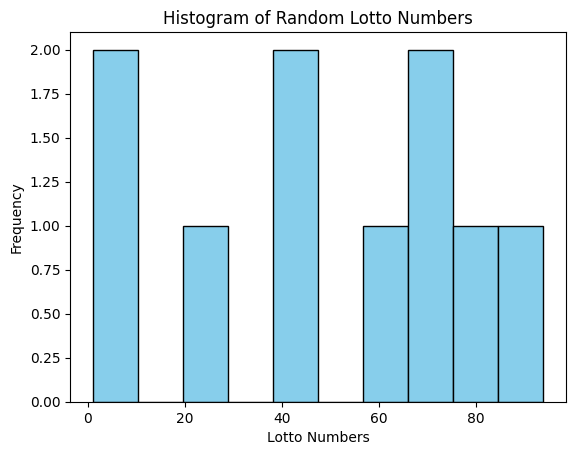

TypeError: Object of type CallbackManagerForToolRun is not JSON serializable

In [61]:
config = {"recursion_limit": 20}
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Get 10 random lotto numbers and plot them on a histogram in 10 bins and tell me what the 10 numbers are at the end")
        ]
    }, config=config
):
    if "__end__" not in s:
        print(s)
        print("----")

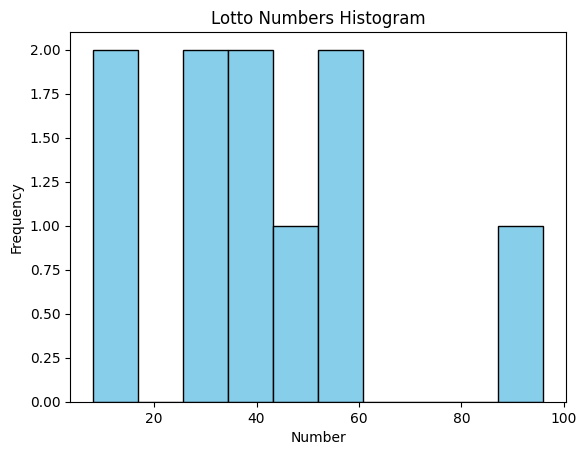

TypeError: Object of type CallbackManagerForToolRun is not JSON serializable

In [62]:
final_response = graph.invoke(
    {
        "messages": [
            HumanMessage(content="Get 10 random lotto numbers and plot them on a histogram in 10 bins and tell me what the 10 numbers are at the end")
        ]
    }, config=config
)

In [63]:
final_response

NameError: name 'final_response' is not defined

In [ ]:
final_response['messages'][1].content